# Distribucion de eventos y generacion de señal

Se creara un Script de python para simular una cadena de eventos con una distribucion diseñada

### Importacion de librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Modelo de pulso

In [2]:
# Definición de la forma del pulso
def radiation_event(t, A, t_0, tau_D, tau_R):
    return (A * ((np.exp(-(t - t_0) / tau_D) - np.exp(-(t - t_0) / tau_R)))) * np.heaviside(t - t_0, 1)

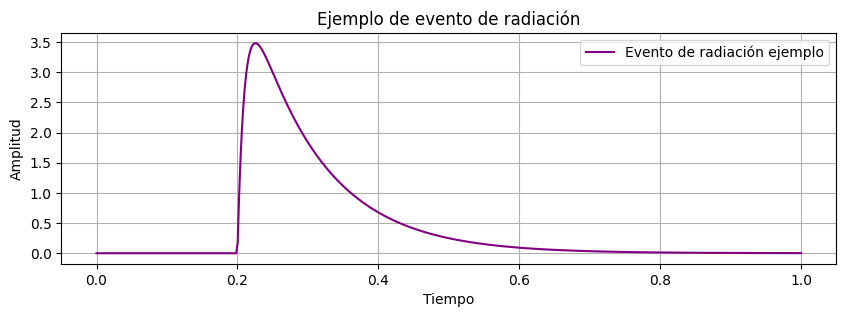

In [72]:
# Ejemplo de un evento de radiación
example_t = np.linspace(0, 1, 500)
example_A = 5  # Amplitud
example_t_0 = 0.2  # Tiempo inicial
example_tau_D = 0.1  # Decaimiento
example_tau_R = 0.01  # Subida
example_pulse = radiation_event(example_t, example_A, example_t_0, example_tau_D, example_tau_R)

plt.figure(figsize=(10, 3))
plt.plot(example_t, example_pulse, label='Evento de radiación ejemplo', color='purple')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Ejemplo de evento de radiación')
plt.legend()
plt.grid()
plt.show()

### Simulacion de los pulsos

In [73]:
# Parámetros de la simulación
num_pulsos = 1000  # Número total de pulsos
tiempo = np.linspace(0, 1, 500)  # Eje de tiempo para cada pulso

# Definir parámetros de las distribuciones
lambda_poisson = 3
media_gauss = 25
sigma_gauss = 5

### Creacion de funcion Monte Carlo

In [74]:
# Generar alturas con Monte Carlo usando la distribución deseada
def monte_carlo_sample(num_samples):
    """
    Generar muestras Monte Carlo basadas en una distribución bimodal deseada
    """
    # Muchos conteos alrededor de 4 eV (Poissoniana concentrada)
    poisson = np.random.poisson(lam=4, size=int(num_samples * 0.4))
    
    # Un pico significativo en 10 eV (Normal muy estrecha)
    pico_central = np.random.normal(loc=10, scale=0.5, size=int(num_samples * 0.3))

    # Distribución gaussiana entre 15 y 35 eV
    gauss = np.random.normal(loc=25, scale=5, size=int(num_samples * 0.3))

    # Combinar y filtrar valores fuera del rango [1.5, 30]
    distribucion = np.concatenate([poisson, pico_central, gauss])
    distribucion = distribucion[(distribucion >= 1.5) & (distribucion <= 30)]

    return distribucion

def monte_carlo_senoidal(num_samples, amplitude=5, frequency=20, min_value=1.5, max_value=30):
    """
    Generar muestras basadas en una distribución senoidal.
    
    Parameters:
    - num_samples: número de muestras a generar.
    - amplitude: amplitud de la onda senoidal.
    - frequency: frecuencia de la onda senoidal.
    - min_value: valor mínimo de energía.
    - max_value: valor máximo de energía.
    
    Returns:
    - distribucion: muestras generadas a partir de la función senoidal.
    """
    # Generar una secuencia de tiempo o valores en el intervalo [0, 2*pi]
    x = np.linspace(0, 2 * np.pi, num_samples)
    
    # Generar una onda senoidal en el intervalo deseado
    senoide = amplitude * np.sin(frequency * x) + amplitude  # Ajuste de amplitud para asegurar valores positivos
    
    # Mapear la onda senoidal a un rango de energía [min_value, max_value]
    distribucion = np.interp(senoide, (senoide.min(), senoide.max()), (min_value, max_value))
    
    # Filtrar valores fuera del rango deseado
    distribucion = distribucion[(distribucion >= min_value) & (distribucion <= max_value)]
    
    return distribucion

def monte_carlo_senoidal_pdf(num_samples, amplitude=1, frequency=4, min_value=1.5, max_value=30):
    """
    Generar muestras a partir de una función de probabilidad senoidal.
    
    La función de densidad de probabilidad tiene la forma de una onda senoidal.
    
    Parameters:
    - num_samples: número de muestras a generar.
    - amplitude: amplitud de la onda senoidal.
    - frequency: frecuencia de la onda senoidal.
    - min_value: valor mínimo de energía.
    - max_value: valor máximo de energía.
    
    Returns:
    - distribucion: muestras generadas a partir de la función senoidal.
    """
    # Generar la función senoidal normalizada
    x = np.linspace(0, 2 * np.pi, num_samples)
    # pdf_senoidal = np.abs(np.sin(frequency * x)*np.exp(-0.4*x)+1)  # Usar valor absoluto para que sea positiva
    pdf_senoidal = np.abs(np.sin(frequency * x)+1)  # Usar valor absoluto para que sea positiva
    
    # Normalizar la PDF para que su área sea 1 (función de densidad de probabilidad válida)
    pdf_senoidal /= np.sum(pdf_senoidal)
    
    # Mapear x al rango de energías [min_value, max_value]
    energy_values = np.linspace(min_value, max_value, num_samples)
    
    # Generar muestras usando muestreo por aceptación
    samples = []
    while len(samples) < num_samples:
        # Proponer una muestra aleatoria
        proposed_sample = np.random.uniform(min_value, max_value)
        
        # Convertir la muestra a su índice en el vector de energía
        idx = int((proposed_sample - min_value) / (max_value - min_value) * (num_samples - 1))
        
        # Generar un valor aleatorio entre 0 y el valor de la PDF en ese punto
        if np.random.uniform(0, 1) < pdf_senoidal[idx]:
            samples.append(proposed_sample)
    
    return np.array(samples)

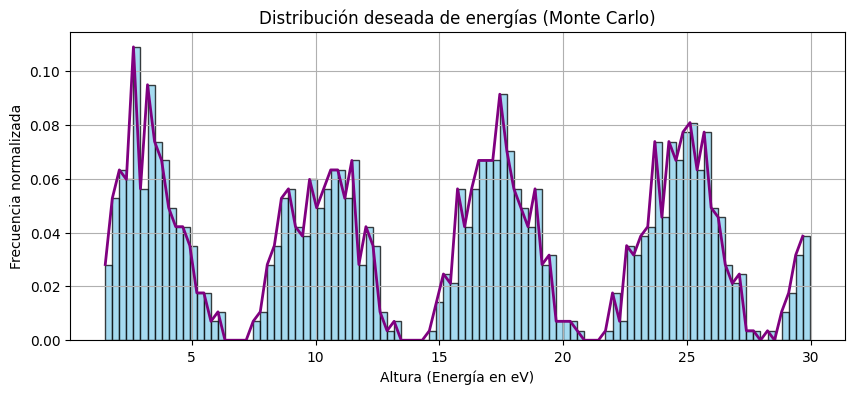

In [75]:
# Generar alturas usando Monte Carlo
# alturas = monte_carlo_sample(num_pulsos)
alturas = monte_carlo_senoidal_pdf(num_pulsos)

# Visualizar la distribución deseada (bimodal con Poisson y Gaussiana) en línea continua
plt.figure(figsize=(10, 4))
# Generar un histograma de la distribución sin bins y graficarlo como una línea continua
count, bins, ignored = plt.hist(alturas, bins=100, alpha=0.75, edgecolor='black', color='skyblue', density=True)
# Graficar la distribución de la altura de los pulsos como una línea
plt.plot(bins[:-1], count, color='purple', lw=2)
plt.xlabel('Altura (Energía en eV)')
plt.ylabel('Frecuencia normalizada')
plt.title('Distribución deseada de energías (Monte Carlo)')
plt.grid()
plt.show()


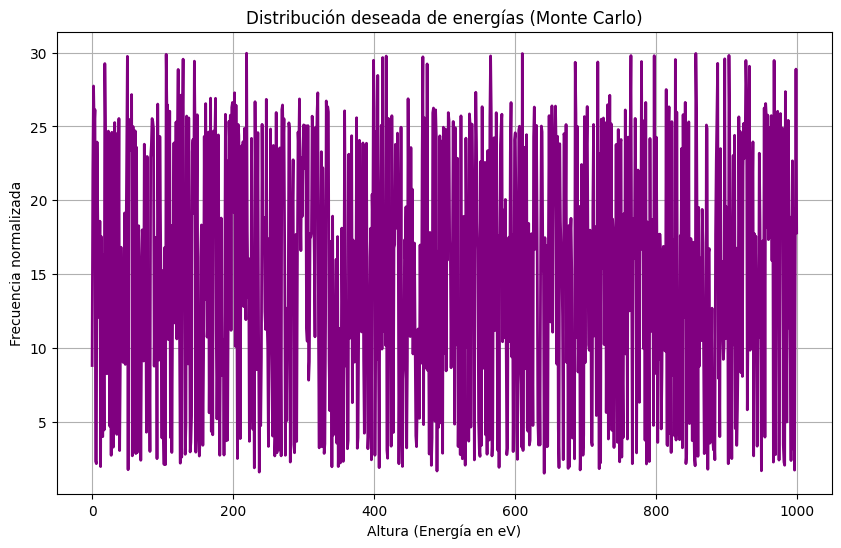

In [76]:
# Visualizar la distribución deseada (bimodal con Poisson y Gaussiana) en línea continua
plt.figure(figsize=(10, 6))
# Generar un histograma de la distribución sin bins y graficarlo como una línea continua
# count, bins, ignored = plt.hist(alturas, bins=100, alpha=0.75, edgecolor='black', color='skyblue', density=True)
# Graficar la distribución de la altura de los pulsos como una línea
plt.plot(alturas, color='purple', lw=2)
plt.xlabel('Altura (Energía en eV)')
plt.ylabel('Frecuencia normalizada')
plt.title('Distribución deseada de energías (Monte Carlo)')
plt.grid()
plt.show()

### Generacion de los pulsos

In [77]:
# Parámetros de los pulsos
tau_D = 0.1  # Constante de tiempo de decaimiento
tau_R = 0.01  # Constante de tiempo de subida

# Generar los pulsos con la forma definida
pulsos = []
for altura in alturas:
    t_0 = np.random.uniform(0, 0.2)  # Tiempo de inicio aleatorio para cada pulso
    pulso = radiation_event(tiempo, altura, t_0, tau_D, tau_R)
    pulsos.append(pulso)


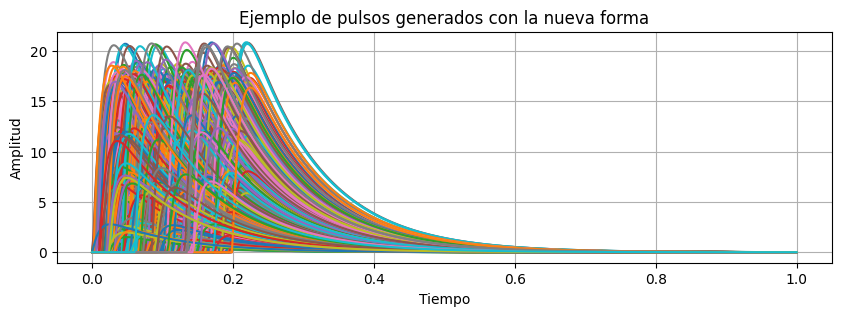

In [78]:
# Visualizar algunos pulsos generados
plt.figure(figsize=(10, 3))
for i in range(900):  # Mostrar los primeros 5 pulsos
    plt.plot(tiempo, pulsos[i], label=f'Pulso {i+1}')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Ejemplo de pulsos generados con la nueva forma')
# plt.legend()
plt.grid()
plt.show()

### Conteo de pulsos e histograma

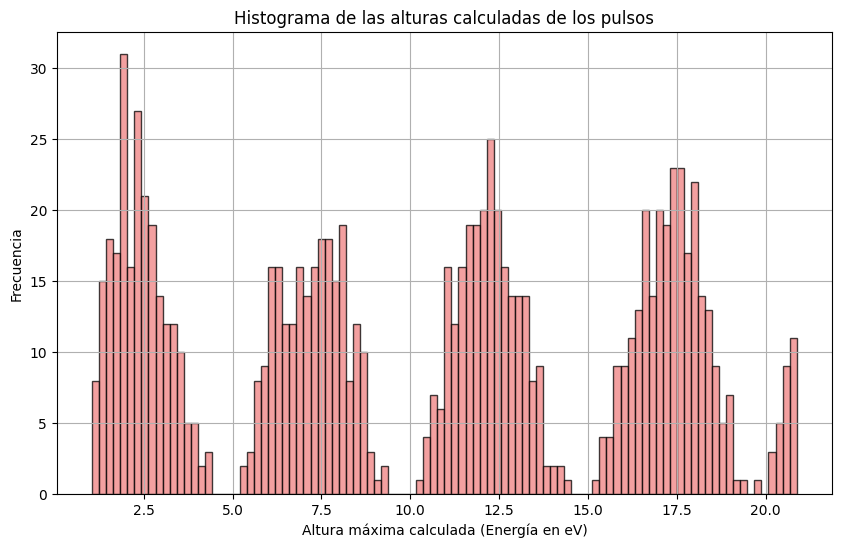

In [79]:
# Determinar las alturas máximas de los pulsos generados
alturas_calculadas = [max(pulso) for pulso in pulsos]

# Visualizar histograma de las alturas calculadas
plt.figure(figsize=(10, 6))
plt.hist(alturas_calculadas, bins=100, alpha=0.75, edgecolor='black', color='lightcoral')
plt.xlabel('Altura máxima calculada (Energía en eV)')
plt.ylabel('Frecuencia')
plt.title('Histograma de las alturas calculadas de los pulsos')
plt.grid()
plt.show()